## Comparing baseline model fits

In [1]:
import numpy as np
import scipy.stats as stats
import nibabel.freesurfer.mghformat as mgh
import h5py

import sys

sys.path.append("..")

from paths import *
from constants import *

sys.path.append(CODE_PATH)

from utils.general_utils import make_iterable

In [2]:
CODE_PATH

'/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/fit_pipeline/'

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors as mcolors

In [4]:
import os 
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [5]:
def reject_outliers(data, m=2.):
    d = np.abs(data - np.mean(data))
    mdev = np.mean(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

In [6]:
subjid = ["01", "02", "03", "04", "05", "06", "07", "08"]
roi = "streams_shrink10"
hemis = ["lh", "rh"]
mapping_func = "PLS"
CV = 0
subsample = 2
ROI_NAMES = ['Early',
             'Midventral',
             'Midlateral',
             'Midparietal',
             'Ventral',
             'Lateral',
             'Parietal']
models = [ "untrained_alexnet", "alexnet_torch", "vgg16", "cornet-s", "resnet18", "resnet50", "resnet101", "slowfast1"]

source_roi = "streams" #_shrink20"
num_splits = 5
n_source_voxels = 10000

In [7]:
means_nc = np.empty((len(subjid), len(ROI_NAMES)))
all_nc = [[[] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

means_s2s = np.empty((len(subjid), len(ROI_NAMES)))
all_s2s_rs = [[[] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

means = np.empty((len(subjid), len(ROI_NAMES), len(models)))
all_rs = [[[[] for m in range(len(models))] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

num_vox = np.zeros((len(hemis)))
for sidx, sid in enumerate(subjid):
    
    for hidx, hemi in enumerate(hemis):
        # Get ROI data
        mgh_file = mgh.load(
            NSDDATA_PATH
            + "freesurfer/subj"
            + sid
            + "/label/"
            + hemi
            + "."
            + roi
            + ".mgz"
        )
        streams = mgh_file.get_fdata()[:, 0, 0]
        num_vox[hidx] = streams[streams != 0].shape[0]
        if hidx > 0:
            streams_trim = np.append(streams_trim, streams[streams != 0])
        else:
            streams_trim = streams[streams != 0]

        # Get noise ceiling estimates
        mgh_file = mgh.load(
            stem
            + "/data/nsddata_betas/ppdata/subj"
            + sid
            + "/nativesurface/betas_fithrf_GLMdenoise_RR/"
            + hemi
            + ".nc_3trials.mgh"
        )
        NC = mgh_file.get_fdata()[:, 0, 0]
        if hidx > 0:
            NC_trim = np.append(NC_trim, NC[streams != 0])
        else:
            NC_trim = NC[streams != 0]
        

        # Get subject 2 subject mapping estimates
        load_path = (RESULTS_PATH
                    + "fits/subj2subj/subj"
                    + sid
                    + "_"
                    + hemi
                    + "_"
                    + source_roi
                    + "_to_"
                    + roi
                    + "_"
                    + str(num_splits)
                    + "splits_"
                    + "_subsample_"
                    + str(n_source_voxels if n_source_voxels is not None else 0)
                    + "voxels.hdf5")
        rsquared_array = {}
        with h5py.File(load_path, "r") as f:
            keys = f.keys()
            for k in keys:
                rsquared_array[k] = f[k][:]
        rs_by_layer = np.zeros((len(ROI_NAMES), int(num_vox[hidx])))
        for lix, layer in enumerate(ROI_NAMES):
            rs_by_layer[lix,:] = rsquared_array[layer] #reshape dict to array
        if hidx > 0:
            max_rs_s2s = np.append(max_rs_s2s, np.amax(rs_by_layer, axis=0))
        else:
            max_rs_s2s = np.amax(rs_by_layer, axis=0)
        
    for r in range(len(ROI_NAMES)):
        all_nc[sidx][r] = NC_trim[streams_trim==r+1]/100
        means_nc[sidx, r] = np.mean(NC_trim[streams_trim==r+1]/100)
    for r in range(len(ROI_NAMES)):
        all_s2s_rs[sidx][r] = max_rs_s2s[streams_trim==r+1]
        means_s2s[sidx,r] =  np.mean(max_rs_s2s[streams_trim==r+1])

    for midx, model_name in enumerate(models):

        if model_name == "untrained_alexnet":
            model_name = "alexnet_torch"
            pretrained = False
        else:
            pretrained = True
        
        for hidx, hemi in enumerate(hemis):

            # get model fits
            load_path = (RESULTS_PATH
                        + "fits/subj"
                        + sid
                        + "_"
                        + hemi
                        + "_"
                        + roi
                        + "_"
                        + model_name
                        + "_"
                        + mapping_func
                        + "_subsample_"
                        + str(subsample)
                        + "_"
                        + str(CV)
                        + "CV_"
                        + ("0pretraining_" if pretrained is False else "")
                        + ("1pretraining_" if model_name == "slowfast1" else "")
                        + "fits"
                        #+ ("_old" if model_name == "slowfast1" else "")
                        + ".hdf5")
            fits = {}
            with h5py.File(load_path, "r") as f:
                keys = f.keys()
                for k in keys:
                    fits[k] = f[k][:]

            if model_name == "alexnet":
                layer_keys = ALEXNET_LAYERS
            elif model_name == "alexnet_torch":
                layer_keys = ALEXNET_TORCH_LAYERS
            elif model_name == "vgg16":
                layer_keys = VGG16_LAYERS
            elif model_name == "resnet18":
                layer_keys = RESNET18_LAYERS
            elif model_name == "resnet50":
                layer_keys = RESNET50_LAYERS
            elif model_name == "resnet101":
                layer_keys = RESNET101_LAYERS
            elif model_name == "cornet-s":
                layer_keys = CORNETS_LAYERS
            elif model_name == "slowfast1":
                layer_keys = SLOWFAST_LAYERS
            layer_keys = [
                item
                for sublist in [
                    [item] if type(item) is not list else item for item in layer_keys
                ]
                for item in sublist
            ]

            rs_by_layer = np.zeros((len(layer_keys), int(num_vox[hidx])))
            for lix, layer in enumerate(layer_keys):
                rs_by_layer[lix,:] = fits[layer] #reshape dict to array
            
            if hidx > 0:
                max_rs = np.append(max_rs, np.amax(rs_by_layer, axis=0))
            else:
                max_rs = np.amax(rs_by_layer, axis=0)

        for r in range(len(ROI_NAMES)):
            all_rs[sidx][r][midx] = max_rs[streams_trim==r+1]
            means[sidx, r, midx] =  np.mean(max_rs[streams_trim==r+1])
    

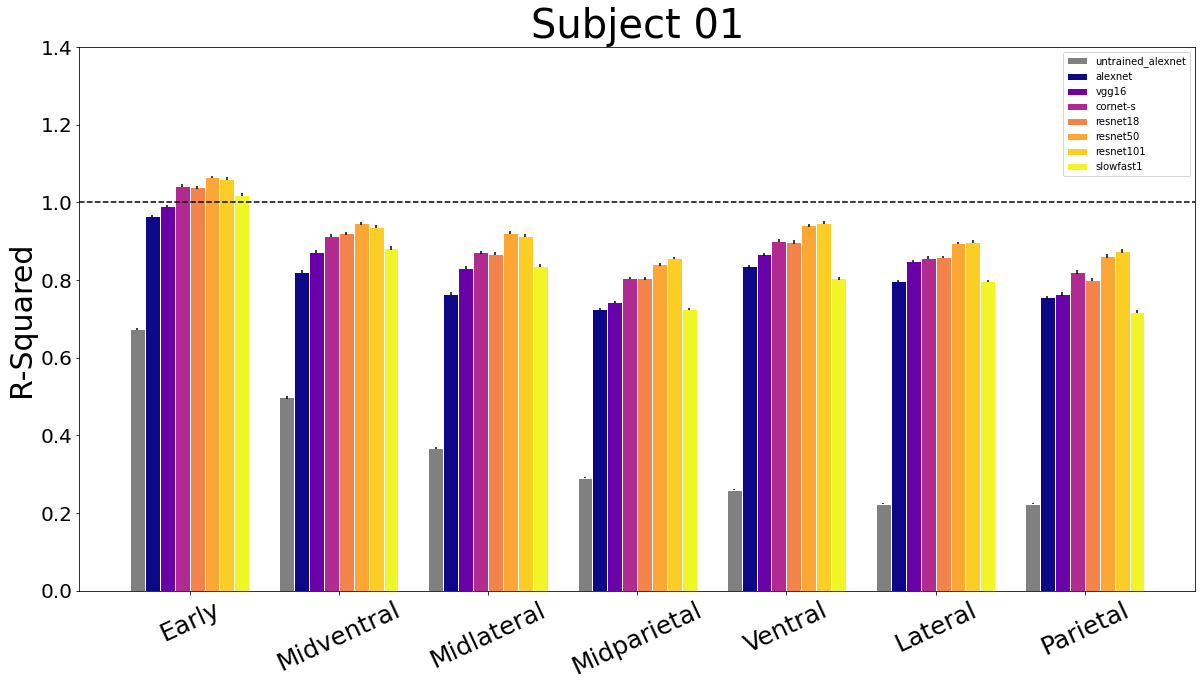

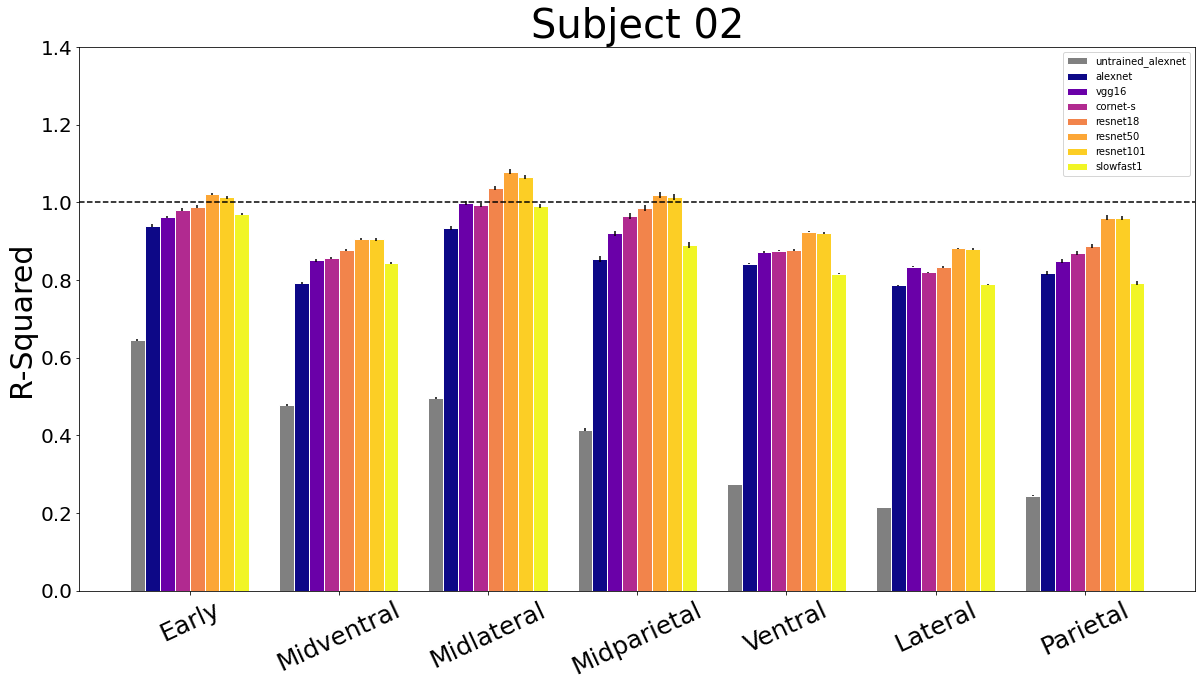

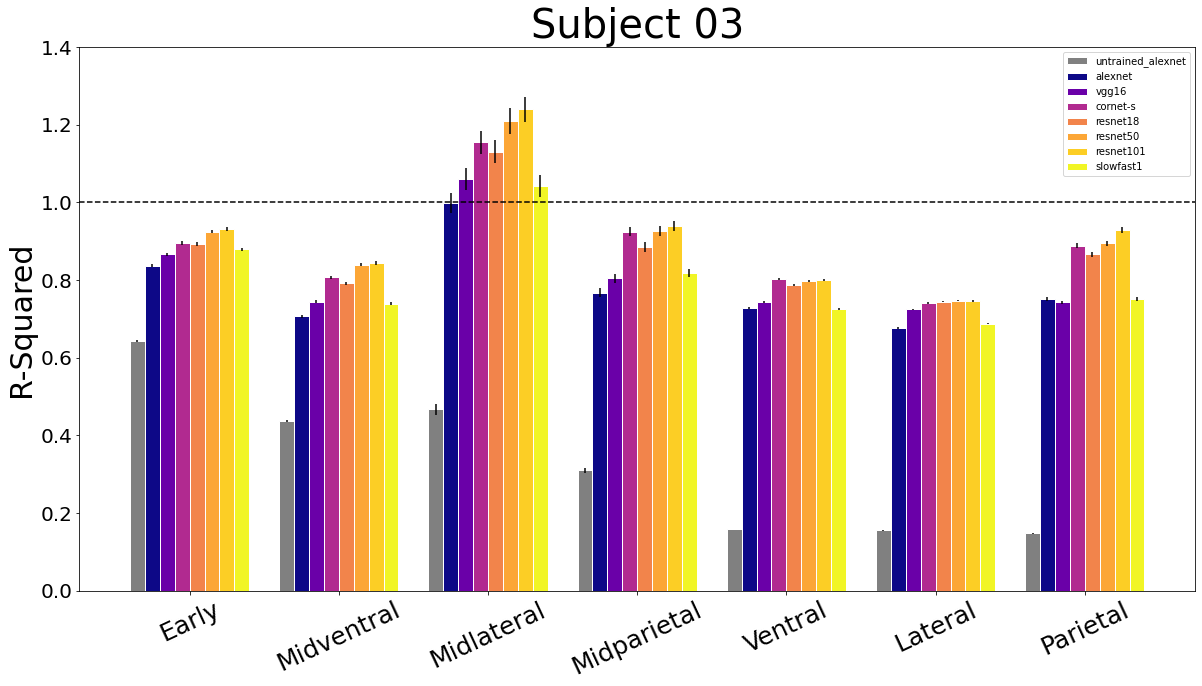

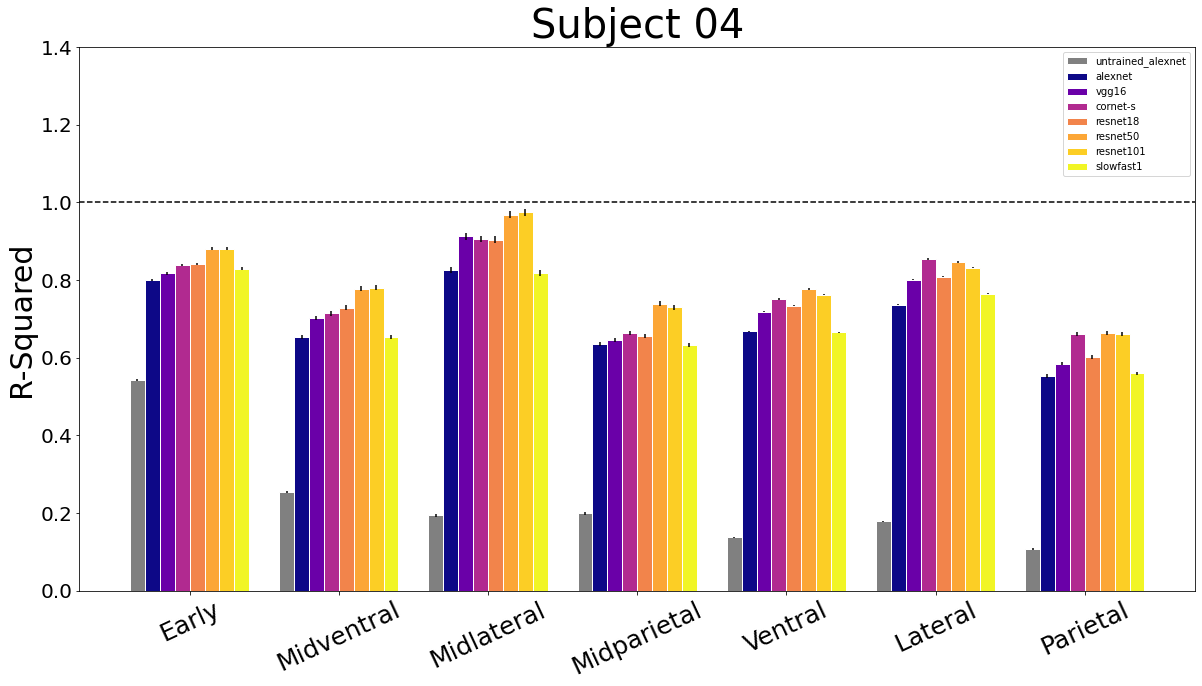

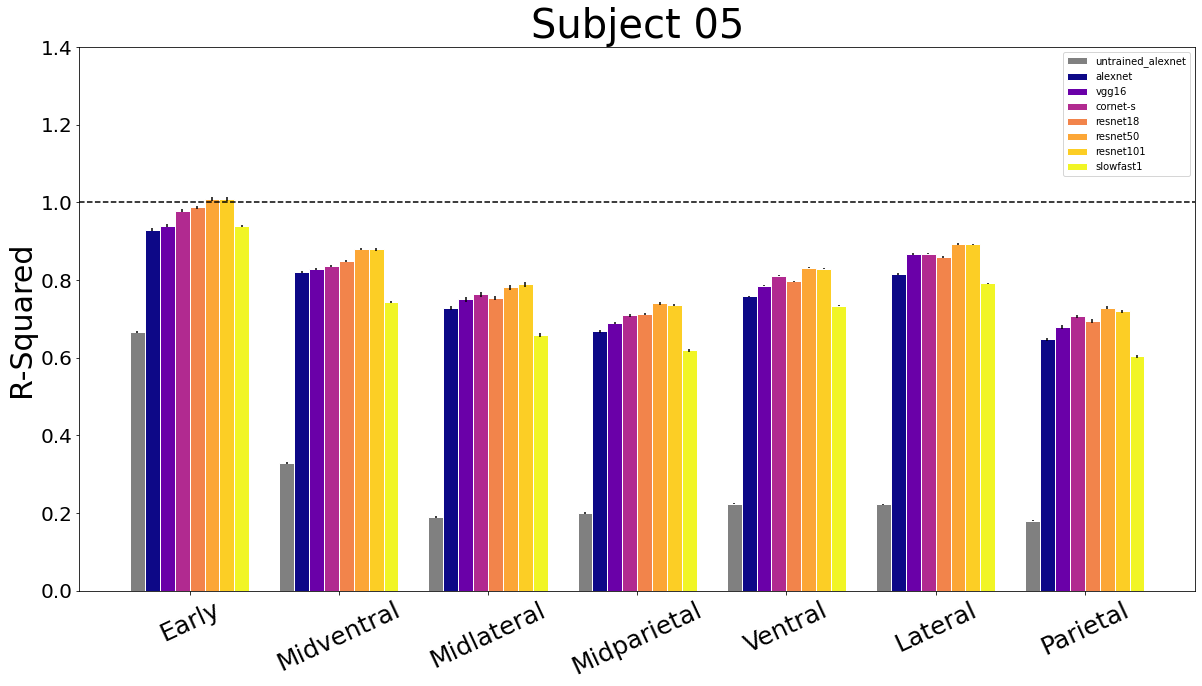

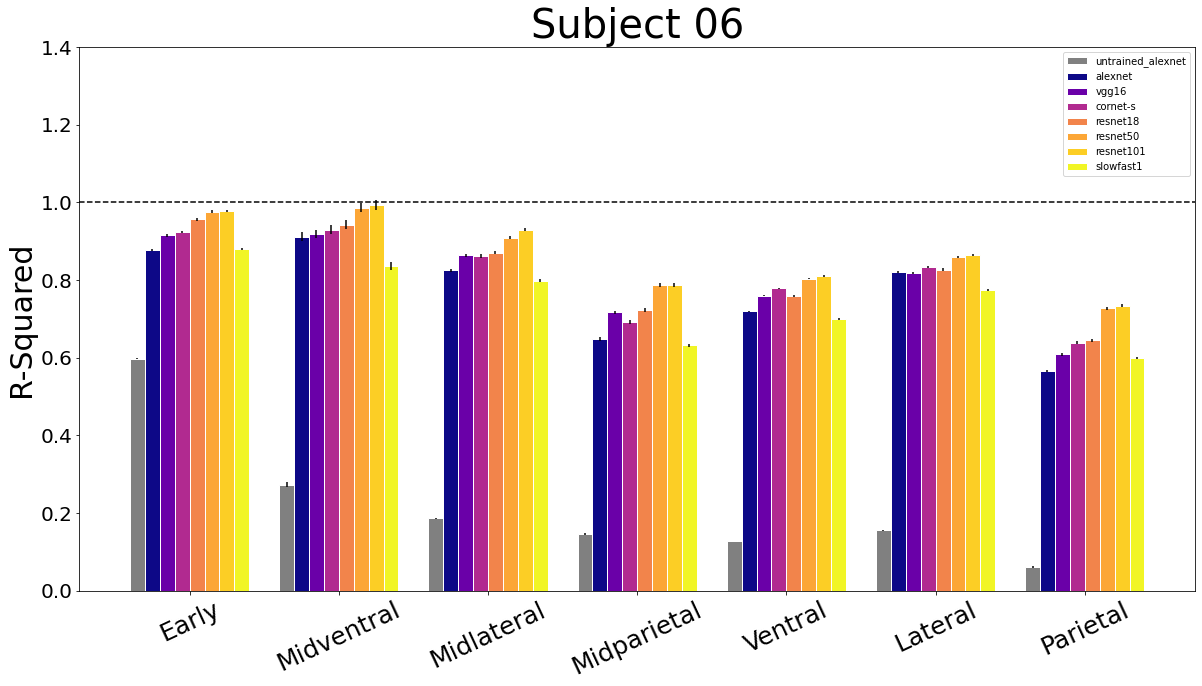

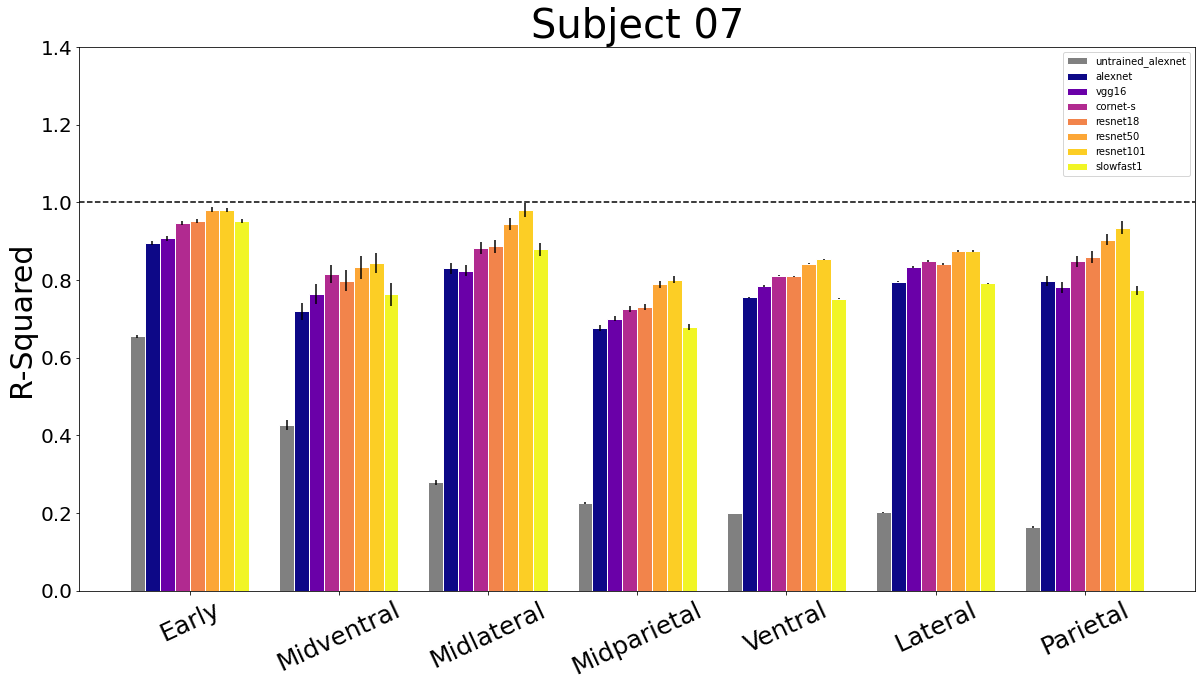

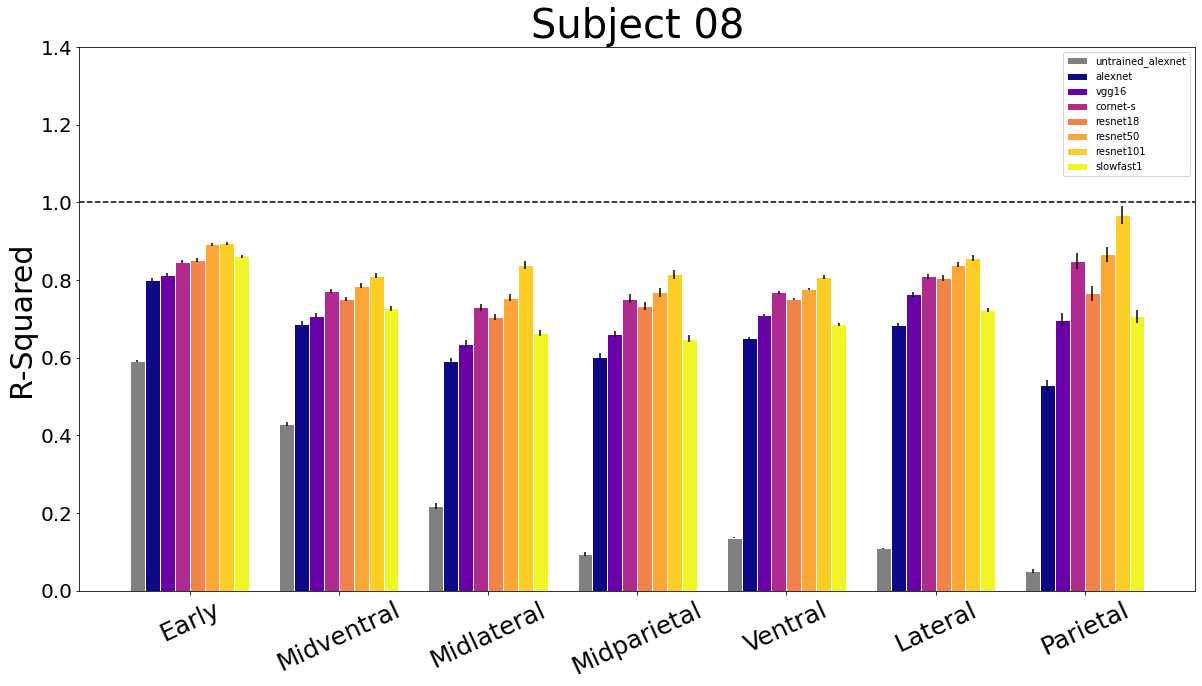

In [8]:
corrected_medians = np.empty((len(subjid), len(ROI_NAMES), len(models)))

cmap = matplotlib.cm.get_cmap('plasma')
rgba = np.zeros((len(models), 4))
color_range = [0, 0, .2, .4, .7, .8, .9, .99]
for midx, model_name in enumerate(models):
    if model_name == "untrained_alexnet":
        rgba[midx,:] = [128/255, 128/255, 128/255, 1]
    else:
        rgba[midx,:] = cmap(color_range[midx])
        
for sidx, sid in enumerate(subjid):
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.patch.set_facecolor('white')
    
    # set width of bars
    barWidth = 0.1
    
    for midx, model_name in enumerate(models):
        
        for r in range(len(ROI_NAMES)):
            corrected_medians[sidx][r][midx] = np.median(reject_outliers(all_rs[sidx][r][midx]/all_s2s_rs[sidx][r]))
                        
        data = [np.median(reject_outliers(all_rs[sidx][r][midx]/all_s2s_rs[sidx][r])) for r in range(len(ROI_NAMES))]
        error = [stats.sem(reject_outliers(all_rs[sidx][r][midx]/all_s2s_rs[sidx][r])) for r in range(len(ROI_NAMES))]

        # Set position of bar on X axis
        if midx == 0:
            base = np.arange(len(data))
            r = [x - (barWidth)*(len(models)/2) for x in base]
        else:
            r = [x + barWidth for x in prev_r]

        # Make the plot
        if model_name == "alexnet_torch":
            plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = rgba[midx], label="alexnet")
        else:
            plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = rgba[midx], label=model_name)
        
        prev_r = r
        
    plt.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')
    plt.xticks([r - barWidth/2 for r in range(len(data))], ROI_NAMES, rotation=25, fontsize=25);

    plt.ylabel('R-Squared',size = 30)
    plt.yticks(fontsize=20)
    
    plt.ylim([0, 1.4])

    title_string = "Subject "
    title_string += sid
    plt.title(title_string,size = 40)

    # Create legend & Show graphic
    plt.legend(fontsize=10)

    save_path = (RESULTS_PATH 
                + "fits/figures/subj"
                + sid
                + "_both_"
                + roi
                + "_PCA_fitcomp_bymodel_norm_by_s2s.png")

    #fig.savefig(save_path)
    plt.show()



### Experimenting with pandas and seaborn

In [9]:
d = {
    'subject_name': np.concatenate((np.tile('subj01',len(ROI_NAMES)*len(models)), 
                                    np.tile('subj02',len(ROI_NAMES)*len(models)), 
                                    np.tile('subj03',len(ROI_NAMES)*len(models)),
                                    np.tile('subj04',len(ROI_NAMES)*len(models)),
                                    np.tile('subj05',len(ROI_NAMES)*len(models)),
                                    np.tile('subj06',len(ROI_NAMES)*len(models)),
                                    np.tile('subj07',len(ROI_NAMES)*len(models)),
                                    np.tile('subj08',len(ROI_NAMES)*len(models)))),
    'roi': np.tile(ROI_NAMES, len(subjid)*len(models)),
    'Model': np.ravel(np.tile(np.ravel([np.tile(m, len(ROI_NAMES)) for m in models]), len(subjid))),
    'corrected': np.swapaxes(corrected_medians,1,2).ravel(),
    'nc': np.ravel(np.tile(means_nc,len(models)))
    
}

In [10]:
print(len(d['subject_name']))
print(len(d['roi']))
print(len(d['Model']))
print(len(d['corrected']))
print(len(d['nc']))

448
448
448
448
448


In [11]:
df = pd.DataFrame(d,columns=['subject_name','roi','Model', 'corrected', 'nc'])
df  

,subject_name,roi,Model,corrected,nc
0,subj01,Early,untrained_alexnet,0.672884,0.543239
1,subj01,Midventral,untrained_alexnet,0.497881,0.478550
2,subj01,Midlateral,untrained_alexnet,0.368401,0.437491
3,subj01,Midparietal,untrained_alexnet,0.291478,0.432921
4,subj01,Ventral,untrained_alexnet,0.260288,0.423189
...,...,...,...,...,...
443,subj08,Midlateral,slowfast1,0.664028,0.285401
444,subj08,Midparietal,slowfast1,0.648901,0.320498
445,subj08,Ventral,slowfast1,0.685651,0.366867
446,subj08,Lateral,slowfast1,0.723020,0.352072


In [12]:
# Wanted palette details
roi_palette = ['#a6a6a6' , '#f4bdd8', '#ccdaff', '#b3ffc6',  '#DC267F' ,'#4d7fff','#006600']
color_codes_wanted = ROI_NAMES
#cdict = dict(zip(color_codes_wanted, [mcolors.to_rgba(c) for c in roi_palette]))
cdict = dict(zip(models, rgba))
#
mcolors.get_named_colors_mapping().update(cdict)
#
model_colors=np.ravel([np.tile(m, len(ROI_NAMES)) for m in models])

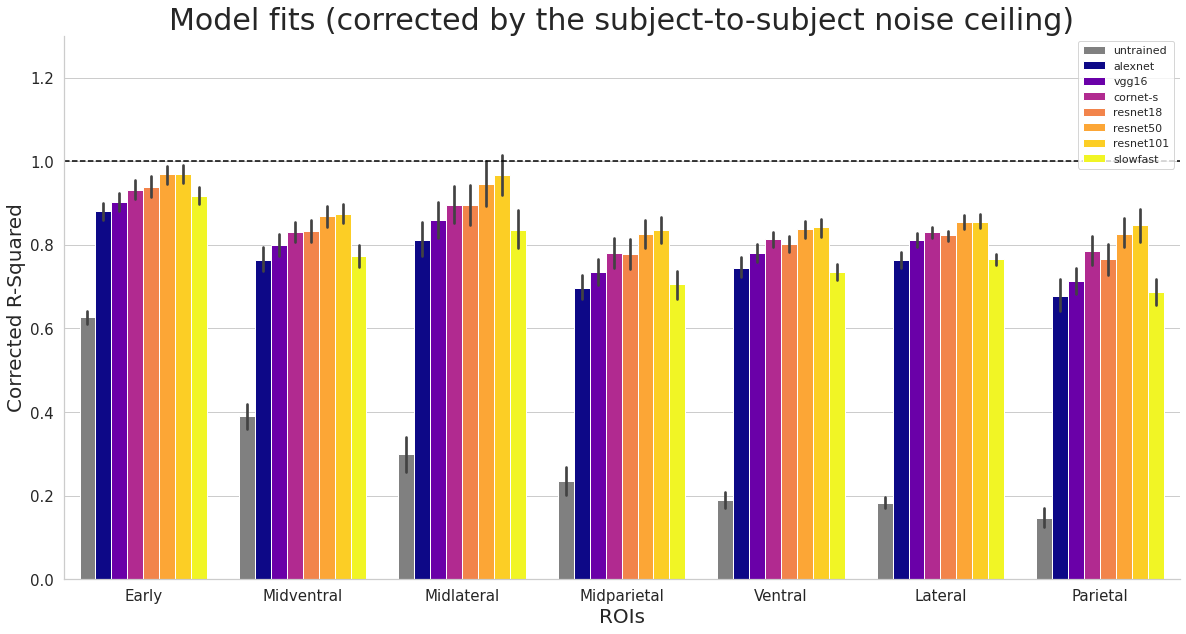

In [13]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="roi", y="corrected", hue="Model",palette='cool_r',data=df, ci=68, ax=ax)

for idx, bar in enumerate(ax.patches):
    bar.set_color(model_colors[idx])
    bar.set_edgecolor("w")
    
# iterate over range of number of rows    
ax.set_xlabel('ROIs', fontsize=20)
ax.set_ylabel('Corrected R-Squared', fontsize=20)
ax.tick_params(labelsize=15)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

h, l = ax.get_legend_handles_labels()
model_labels = [ "untrained", "alexnet", "vgg16", "cornet-s", "resnet18", "resnet50", "resnet101", "slowfast"]
ax.legend(h, model_labels)

plt.title('Model fits (corrected by the subject-to-subject noise ceiling)',size = 30)
plt.ylim([0, 1.3])

ax.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')

save_path = (RESULTS_PATH 
                + "fits/figures/groupavg_both_"
                + roi
                + "_PCA_fitcomp_bymodel_norm_by_s2s.png")

#fig.savefig(save_path)
